In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from itertools import product
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import torch.nn.init as init

In [2]:
#check for GPU availability
torch.cuda.is_available()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Define Functions

## 1) function to preprocess (1-hot encode) MONK data

In [3]:
def preprocess_monk(file_name):
    '''
    Load data from the Monk dataset and preprocess using one-hot encoding.

    Parameters:
    - file_name (str): The file name of the dataset.

    Returns:
    - x (torch.Tensor): Input data after one-hot encoding.
    - y (torch.Tensor): Target data.
    '''

    # load the dataset, split into input (X) and output (y) variables
    df = pd.read_csv(file_name, delimiter=' ', header=None,
                     names=['_','target', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'data_number'],
                     index_col=False)

    # Extract input features and target variable
    x1, x2, x3, x4, x5, x6, target = (np.array(df[feature]) for feature in ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'target'])

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False)

    # Reshape and transform x1 using one-hot encoding
    input_one_hot = encoder.fit_transform(x1.reshape(-1, 1))

    # Loop through the remaining input features and concatenate one-hot encoded values
    for x in [x2,x3,x4,x5,x6]:
        data =x.reshape(-1, 1)
        one_hot_encoded = encoder.fit_transform(data)
        input_one_hot = np.hstack((input_one_hot, one_hot_encoded))

    # Convert to PyTorch tensors
    x = torch.tensor(input_one_hot, dtype=torch.float32)#.cuda()
    y = torch.tensor(target, dtype=torch.float32).reshape(-1,1)#.cuda()

    return x, y

## Function to plot training curves

In [4]:
def plot_training_curves(epoch, train_losses, test_losses, train_accuracies, test_accuracies, hyperparams):
    '''
    Plot training and test curves for loss and accuracy.

    Parameters:
    - epoch (int): The number of epochs.
    - train_losses (list): List of training losses for each epoch.
    - test_losses (list): List of test losses for each epoch.
    - train_accuracies (list): List of training accuracies for each epoch.
    - test_accuracies (list): List of test accuracies for each epoch.
    - hyperparams (list): List of hyperparameters [hidden_units, lr, alpha, batch_size, lambda].

    Returns:
    None
    '''
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Batch Size={hyperparams[3]}, Hidden Units={hyperparams[0]}, Eta={hyperparams[1]}, Alpha={hyperparams[2]}, Lambda={hyperparams[4]}')
    # Loss plots
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch + 2), train_losses, label='Training Loss', color = 'red')
    plt.plot(range(1, epoch + 2), test_losses, label='Test Loss', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plots
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy', color='red')
    plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Define the model

In [5]:
# Define the classifier

class MonkClassifier(nn.Module):
    def __init__(self, hidden_size, input_size=17, output_size=1, weight_init_constant=0.01):
        super(MonkClassifier, self).__init__()

        # Custom weight initialization function
        def init_weights(m):
            if type(m) == nn.Linear:
                if hasattr(m, 'weight') and m.weight is not None:
                    init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                    if m.bias is not None:
                        init.constant_(m.bias, 0)

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

        # Apply custom weight initialization to linear layers
        self.apply(init_weights)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        output = self.sigmoid(x)
        return output

In [6]:
def training_model(x_train, y_train, x_test, y_test, hidden_size,learning_rate, momentum, bs, reg_coeff, num_epochs=1000, plot_curves=False):
    '''
    Train a Monk classifier model.

    Parameters:
    - x_train (torch.Tensor): Training input data.
    - y_train (torch.Tensor): Training target data.
    - x_test (torch.Tensor): Test (or Validation) input data.
    - y_test (torch.Tensor): Test (or Validation) target data.
    - hidden_size (int): Size of the hidden layer in the model.
    - learning_rate (float): Learning rate for the optimizer.
    - momentum (float): Momentum for the optimizer.
    - batch_size (int): Batch size for training and testing.
    - reg_coeff (float): Regularization coefficient for weight decay.
    - num_epochs (int): Maximum number of training epochs (default: 1000).
    - plot_curves (bool): Whether to plot training curves (default: False).

    Returns:
    - epoch (int): Number of epochs completed.
    - train_loss (float): Final training loss.
    - test_loss (float): Final test (or validation) loss.
    - train_accuracy (float): Final training accuracy.
    - test_accuracy (float): Final test (or validation) accuracy.
    '''

    # Create an instance of the model
    model = MonkClassifier(hidden_size)
    #model.to(device)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg_coeff)

    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)

    if plot_curves:
        # Lists to store training and test losses for plotting
        train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    # parameters to stop at training convergence
    prev_loss = float('inf')
    prev_accuracy = 0
    patience_counter, patience = 0, 20

    for epoch in range(num_epochs):
        total_loss, total_accuracy = 0.0, 0.0
        # Mini-batch training

        model.train()  # Set the model to training mode
        for inputs, labels in train_dataloader:
            optimizer.zero_grad()   # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)   # Compute the loss
            loss.backward() # Backward pass
            optimizer.step()    # Update weights


            #prev_loss = loss.item()
            # Accumulate the total loss for this epoch
            total_loss += loss.item()

            # Calculate training accuracy
            predicted_labels = torch.round(outputs)
            correct_predictions = (predicted_labels == labels).sum().item()
            total_samples = labels.size(0)
            total_accuracy += correct_predictions / total_samples

        # Print average training loss and accuracy for the epoch
        average_loss = total_loss / len(train_dataloader)
        average_accuracy = total_accuracy / len(train_dataloader)

        #print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}, '
        #      f'Accuracy: {average_accuracy:.4f}')

        if plot_curves:
            train_losses.append(average_loss)
            train_accuracies.append(average_accuracy)

        # Evaluation on the test set
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            total_test_loss, total_test_accuracy = 0.0, 0.0
            for test_inputs, test_labels in test_dataloader:
                test_outputs = model(test_inputs)
                test_loss = criterion(test_outputs, test_labels)
                total_test_loss += test_loss.item()

                # Calculate test accuracy
                predicted_labels = torch.round(test_outputs)
                correct_predictions = (predicted_labels == test_labels).sum().item()
                total_samples = test_labels.size(0)
                total_test_accuracy += correct_predictions / total_samples

            average_test_loss = total_test_loss / len(test_dataloader)
            average_test_accuracy = total_test_accuracy / len(test_dataloader)

            #print(f'Test - Epoch [{epoch+1}/{num_epochs}], Loss: {average_test_loss:.4f},'
            #       f'Accuracy: {average_test_accuracy:.4f}')

            if plot_curves:
                test_accuracies.append(average_test_accuracy)
                test_losses.append(average_test_loss)

        # Check for convergence
        if abs(prev_loss - average_loss) < 1e-4:
            patience_counter += 1
        else:
            patience_counter = 0

        if patience_counter == patience:
        #    print(f"Convergence reached. at epoch {epoch+1} Stopping training.")
            break

        #prev_accuracy = average_accuracy
        prev_loss = average_loss

    print(f'N. Epochs = {epoch+1} - Loss (train | test)= ({average_loss:.4} | {average_test_loss:.4}) - Accuracy (train | test) = ({average_accuracy} | {average_test_accuracy})')

    if plot_curves:
        hyperparams = [hidden_size,learning_rate, momentum, bs, reg_coeff, num_epochs]
        plot_training_curves(epoch, train_losses, test_losses, train_accuracies, test_accuracies, hyperparams)

    return epoch+1, average_loss, average_test_loss, average_accuracy, average_test_accuracy

In [7]:
def perform_grid_search_kfold(hidden_sizes, learning_rates, momentums, batch_sizes, reg_coeffs, k_folds, x, y, plot_curves=False):
    '''
    Perform grid search with k-fold cross-validation for Monk classifier hyperparameters.

    Parameters:
    - hidden_sizes (list): List of hidden layer sizes to explore.
    - learning_rates (list): List of learning rates to explore.
    - momentums (list): List of momentum values to explore.
    - batch_sizes (list): List of batch sizes to explore.
    - reg_coeffs (list): List of regularization coefficients to explore.
    - k_folds (int): Number of folds for cross-validation.
    - x (torch.Tensor): Input data.
    - y (torch.Tensor): Target data.
    - plot_curves (bool): Whether to plot training curves for each hyperparameter combination (default: False).

    Returns:
    - best_hyperparams (list): List of best hyperparameters based on highest average validation accuracy.
    '''

    best_acc = 0
    best_hyperparams = []

    for hidden_size, learning_rate, momentum, bs, reg_coeff in product(hidden_sizes,learning_rates,momentums,batch_sizes, reg_coeffs):
        print(f'hidden_size={hidden_size}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff}')

        kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

        # Lists to store training and validation losses and accuracies for each epoch
        train_losses, val_losses, train_acc, val_acc = [], [], [], []

        # Perform K-fold cross-validation
        for fold, (train_indices, val_indices) in enumerate(kf.split(x,y)):
            #print(f"\nFold {fold + 1}/{k_folds}")

            # Split the data into training and validation (or test) sets
            X_train, X_val = x[train_indices], x[val_indices]
            Y_train, Y_val = y[train_indices], y[val_indices]

            max_epoch, average_loss, average_val_loss, average_accuracy, average_val_accuracy = training_model(
                x_train=X_train, y_train=Y_train, x_test=X_val, y_test=Y_val,
                hidden_size=hidden_size, learning_rate=learning_rate, momentum=momentum,
                bs=bs, reg_coeff=reg_coeff, plot_curves=plot_curves)

            train_losses.append(average_loss)
            val_losses.append(average_val_loss)
            train_acc.append(average_accuracy)
            val_acc.append(average_val_accuracy)

        print(f'Final Results: hidden_size={hidden_size}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff} --> '
            f'train_loss = {np.mean(train_losses):.4} +- {np.std(train_losses):.4} | '
            f'val_loss = {np.mean(val_losses):.4} +- {np.std(val_losses):.4}'
            f'train_acc = {np.mean(train_acc):.4} +- {np.std(train_acc):.4} | '
            f'val_acc = {np.mean(val_acc):.4} +- {np.std(val_acc):.4}')

        if np.mean(val_acc) >= best_acc:
            best_acc = np.mean(val_acc)
            best_hyperparams = [hidden_size, learning_rate, momentum, bs, reg_coeff]

    print(best_hyperparams)
    return best_hyperparams

In [12]:
def train_with_different_initializations(x_train, y_train, x_test, y_test,
                                         hidden_size,learning_rate, momentum,
                                         bs, reg_coeff, num_epochs=1000,
                                         plot_curves=False, N = 5):
    '''
    train the model N times with different weight initializations,
    to estimate the model performances with mean and variance
    '''
    train_losses, test_losses, train_accs, test_accs = [], [], [], []
    for i in range (0,N):
        _, train_loss, test_loss, train_acc, test_acc = training_model(x_train,
                        y_train,
                        x_test,
                        y_test,
                        hidden_size,
                        learning_rate,
                        momentum,
                        bs,
                        reg_coeff,
                        plot_curves=plot_curves)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    print(f'Train Loss: {np.mean(train_losses):.4} +- {np.std(train_losses):.4}')
    print(f'Test Loss: {np.mean(test_losses):.4} +- {np.std(test_losses):.4}')
    print(f'Train Acc: {np.mean(train_accs)*100:.4} +- {np.std(train_accs)*100:.4} %')
    print(f'Test Acc: {np.mean(test_accs)*100:.4} +- {np.std(test_accs)*100:.4} %')


# Monk 1

In [71]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-1.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-1.test')

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

torch.Size([124, 17])
torch.Size([124, 1])
torch.Size([432, 17])
torch.Size([432, 1])


## Perform Model Selection using a grid serch with k-fold cross validation

inizialmente modificare gli iperparametri ad occhio per avere un'idea di cosa succede,
poi fare una grid search più fine 

In [76]:
hidden_sizes = [5]
learning_rates = [0.25,0.3,0.35]
momentums = [0.75,0.8,0.85]
batch_sizes = [5]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=5; lr=0.25; alpha = 0.75; batch size = 5; lambda = 0
N. Epochs = 67 - Loss (train | test)= (0.0006153 | 0.02082) - Accuracy (train | test) = (1.0 | 0.96)
N. Epochs = 73 - Loss (train | test)= (0.01076 | 0.1875) - Accuracy (train | test) = (0.99 | 0.8)
N. Epochs = 55 - Loss (train | test)= (0.0008622 | 0.00313) - Accuracy (train | test) = (1.0 | 1.0)
N. Epochs = 52 - Loss (train | test)= (0.0008719 | 0.001738) - Accuracy (train | test) = (1.0 | 1.0)
N. Epochs = 48 - Loss (train | test)= (0.05036 | 0.1204) - Accuracy (train | test) = (0.95 | 0.8800000000000001)
Final Results: hidden_size=5; lr=0.25; alpha = 0.75; batch size = 5; lambda = 0 --> train_loss = 0.01269 +- 0.01922 | val_loss = 0.06671 +- 0.07462train_acc = 0.988 +- 0.01939 | val_acc = 0.928 +- 0.07756
hidden_size=5; lr=0.25; alpha = 0.8; batch size = 5; lambda = 0
N. Epochs = 52 - Loss (train | test)= (0.000645 | 0.008619) - Accuracy (train | test) = (1.0 | 1.0)
N. Epochs = 72 - Loss (train | test)= (0.01049 | 0.15

## Train the model (with best hyperparameters) using different weights initiaizatons
in order to estimate a mean and variance for the performance

In [77]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False)

N. Epochs = 37 - Loss (train | test)= (0.000189 | 0.0007305) - Accuracy (train | test) = (1.0 | 1.0)
N. Epochs = 302 - Loss (train | test)= (0.04002 | 0.08284) - Accuracy (train | test) = (0.9600000000000002 | 0.9172413793103451)
N. Epochs = 53 - Loss (train | test)= (0.0003979 | 0.00137) - Accuracy (train | test) = (1.0 | 1.0)
N. Epochs = 38 - Loss (train | test)= (0.0004737 | 0.000811) - Accuracy (train | test) = (1.0 | 1.0)
N. Epochs = 63 - Loss (train | test)= (0.000493 | 0.002211) - Accuracy (train | test) = (1.0 | 1.0)
Train Loss: 0.008314 +- 0.01585
Test Loss: 0.01759 +- 0.03263
Train Acc: 99.2 +- 1.6 %
Test Acc: 98.34 +- 3.31 %


# Retrain the model to make final plots

N. Epochs = 48 - Loss (train | test)= (0.0005015 | 0.0006276) - Accuracy (train | test) = (1.0 | 1.0)


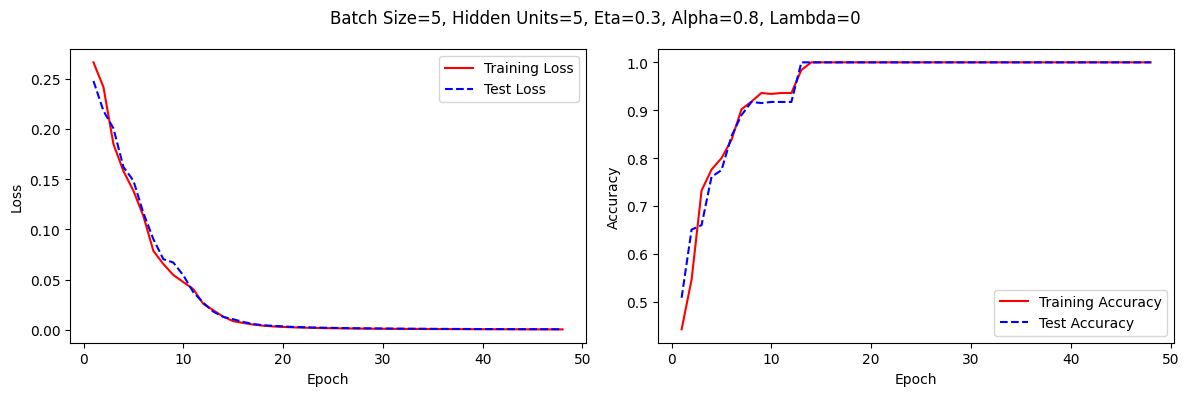

(48, 0.0005015497756539844, 0.0006275818498987315, 1.0, 1.0)

In [78]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)

# Monk 2

In [79]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-2.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-2.test')

In [80]:
hidden_sizes = [5]
learning_rates = [0.1]
momentums = [0.8]
batch_sizes = [4]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=5; lr=0.1; alpha = 0.8; batch size = 4; lambda = 0
N. Epochs = 47 - Loss (train | test)= (0.0006027 | 0.0007121) - Accuracy (train | test) = (1.0 | 1.0)
N. Epochs = 67 - Loss (train | test)= (0.001047 | 0.001194) - Accuracy (train | test) = (1.0 | 1.0)
N. Epochs = 98 - Loss (train | test)= (0.008078 | 0.164) - Accuracy (train | test) = (0.9926470588235294 | 0.8333333333333334)
N. Epochs = 50 - Loss (train | test)= (0.0005706 | 0.0006581) - Accuracy (train | test) = (1.0 | 1.0)
N. Epochs = 47 - Loss (train | test)= (0.0006409 | 0.001052) - Accuracy (train | test) = (1.0 | 1.0)
Final Results: hidden_size=5; lr=0.1; alpha = 0.8; batch size = 4; lambda = 0 --> train_loss = 0.002188 +- 0.00295 | val_loss = 0.03352 +- 0.06524train_acc = 0.9985 +- 0.002941 | val_acc = 0.9667 +- 0.06667
[5, 0.1, 0.8, 4, 0]


In [81]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False)

N. Epochs = 61 - Loss (train | test)= (0.0008242 | 0.00122) - Accuracy (train | test) = (1.0 | 1.0)
N. Epochs = 43 - Loss (train | test)= (0.000471 | 0.0005891) - Accuracy (train | test) = (1.0 | 1.0)
N. Epochs = 60 - Loss (train | test)= (0.0008516 | 0.007712) - Accuracy (train | test) = (1.0 | 0.9814814814814815)
N. Epochs = 77 - Loss (train | test)= (0.0007306 | 0.01715) - Accuracy (train | test) = (1.0 | 0.9814814814814815)
N. Epochs = 60 - Loss (train | test)= (0.000779 | 0.0008585) - Accuracy (train | test) = (1.0 | 1.0)
Train Loss: 0.0007313 +- 0.0001365
Test Loss: 0.005505 +- 0.006396
Train Acc: 100.0 +- 0.0 %
Test Acc: 99.26 +- 0.9072 %


N. Epochs = 78 - Loss (train | test)= (0.02973 | 0.05884) - Accuracy (train | test) = (0.9709302325581395 | 0.9444444444444444)


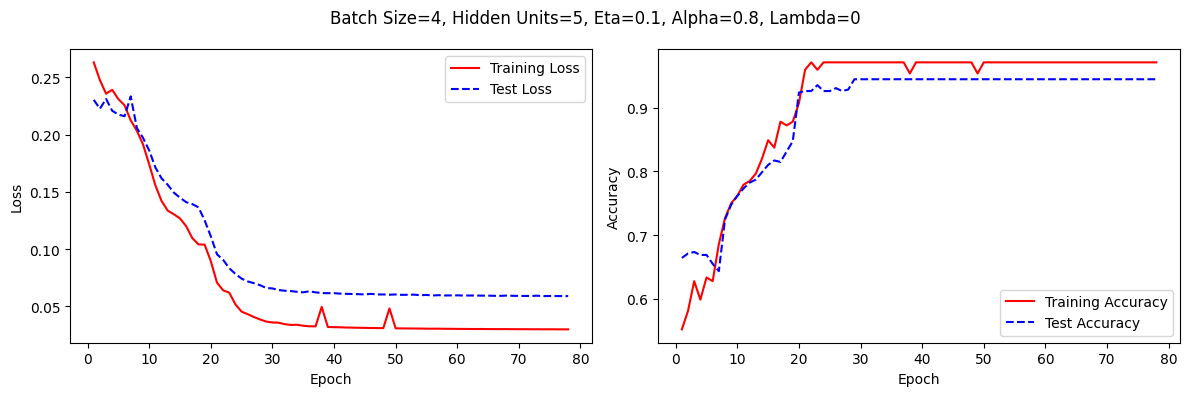

(78,
 0.029733322243563908,
 0.058836323633144234,
 0.9709302325581395,
 0.9444444444444444)

In [82]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)

# Monk 3 (no regularization)

In [22]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-3.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-3.test')

In [27]:
hidden_sizes = [5]
learning_rates = [0.1,0.01,0.001]
momentums = [0.6,0.7,0.8,0.9]
batch_sizes = [1,4]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=5; lr=0.1; alpha = 0.6; batch size = 1; lambda = 0
N. Epochs = 75 - Loss (train | test)= (0.01065 | 0.0105) - Accuracy (train | test) = (0.9896907216494846 | 1.0)
N. Epochs = 122 - Loss (train | test)= (0.01093 | 0.1548) - Accuracy (train | test) = (0.9896907216494846 | 0.84)
N. Epochs = 75 - Loss (train | test)= (0.01087 | 0.0367) - Accuracy (train | test) = (0.9897959183673469 | 0.9583333333333334)
N. Epochs = 68 - Loss (train | test)= (0.0007179 | 0.111) - Accuracy (train | test) = (1.0 | 0.875)
N. Epochs = 64 - Loss (train | test)= (0.0208 | 0.1372) - Accuracy (train | test) = (0.9795918367346939 | 0.8333333333333334)
Final Results: hidden_size=5; lr=0.1; alpha = 0.6; batch size = 1; lambda = 0 --> train_loss = 0.01079 +- 0.006353 | val_loss = 0.09004 +- 0.05662train_acc = 0.9898 +- 0.006454 | val_acc = 0.9013 +- 0.06643
hidden_size=5; lr=0.1; alpha = 0.6; batch size = 4; lambda = 0
N. Epochs = 212 - Loss (train | test)= (0.02048 | 0.001214) - Accuracy (train | test) = 

In [24]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False)

N. Epochs = 1000 - Loss (train | test)= (0.05185 | 0.04641) - Accuracy (train | test) = (0.9453125 | 0.9629629629629629)
N. Epochs = 1000 - Loss (train | test)= (0.06414 | 0.04443) - Accuracy (train | test) = (0.8984375 | 0.9675925925925926)
N. Epochs = 1000 - Loss (train | test)= (0.04862 | 0.04229) - Accuracy (train | test) = (0.9453125 | 0.9675925925925926)
N. Epochs = 1000 - Loss (train | test)= (0.04287 | 0.03955) - Accuracy (train | test) = (0.9453125 | 0.9606481481481481)
N. Epochs = 1000 - Loss (train | test)= (0.07353 | 0.04893) - Accuracy (train | test) = (0.9140625 | 0.9722222222222222)
Train Loss: 0.0562 +- 0.01111
Test Loss: 0.04432 +- 0.003241
Train Acc: 92.97 +- 1.976 %
Test Acc: 96.62 +- 0.4036 %


N. Epochs = 721 - Loss (train | test)= (0.02354 | 0.02757) - Accuracy (train | test) = (0.9754098360655737 | 0.9444444444444444)


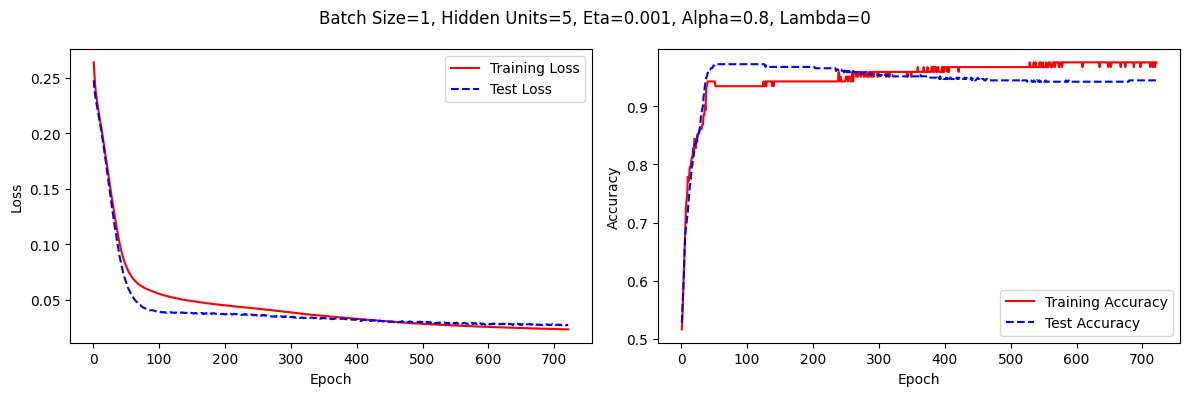

(721,
 0.023540163203455283,
 0.02756927006198271,
 0.9754098360655737,
 0.9444444444444444)

In [28]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)

# Monk 3 (with regularization)

In [ ]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-3.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-3.test')

In [ ]:
hidden_sizes = [8]
learning_rates = [0.001]
momentums = [0.6]
batch_sizes = [1]
reg_coeffs = [0.01]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=8; lr=0.001; alpha = 0.6; batch size = 1; lambda = 0.01
N. Epochs = 278 - Loss (train | test)= (0.07301 | 0.04325) - Accuracy (train | test) = (0.9175257731958762 | 1.0)
N. Epochs = 230 - Loss (train | test)= (0.05707 | 0.1144) - Accuracy (train | test) = (0.9484536082474226 | 0.88)
N. Epochs = 249 - Loss (train | test)= (0.06873 | 0.05307) - Accuracy (train | test) = (0.9285714285714286 | 0.9583333333333334)
N. Epochs = 246 - Loss (train | test)= (0.05554 | 0.1326) - Accuracy (train | test) = (0.9489795918367347 | 0.875)
N. Epochs = 254 - Loss (train | test)= (0.06527 | 0.06392) - Accuracy (train | test) = (0.9285714285714286 | 0.9583333333333334)
Final Results: hidden_size=8; lr=0.001; alpha = 0.6; batch size = 1; lambda = 0.01 --> train_loss = 0.06392 +- 0.006705 | val_loss = 0.08145 +- 0.03542train_acc = 0.9344 +- 0.01235 | val_acc = 0.9343 +- 0.04886
[8, 0.001, 0.6, 1, 0.01]


In [ ]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False)

N. Epochs = 237 - Loss (train | test)= (0.06637 | 0.0526) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)
N. Epochs = 179 - Loss (train | test)= (0.06519 | 0.05192) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)
N. Epochs = 236 - Loss (train | test)= (0.06653 | 0.05262) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)
N. Epochs = 246 - Loss (train | test)= (0.06458 | 0.05125) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)
N. Epochs = 185 - Loss (train | test)= (0.06438 | 0.05267) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)
Train Loss: 0.06541 +- 0.0008907
Test Loss: 0.05221 +- 0.0005542
Train Acc: 93.44 +- 1.11e-14 %
Test Acc: 97.22 +- 1.11e-14 %


N. Epochs = 259 - Loss (train | test)= (0.06466 | 0.05075) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)


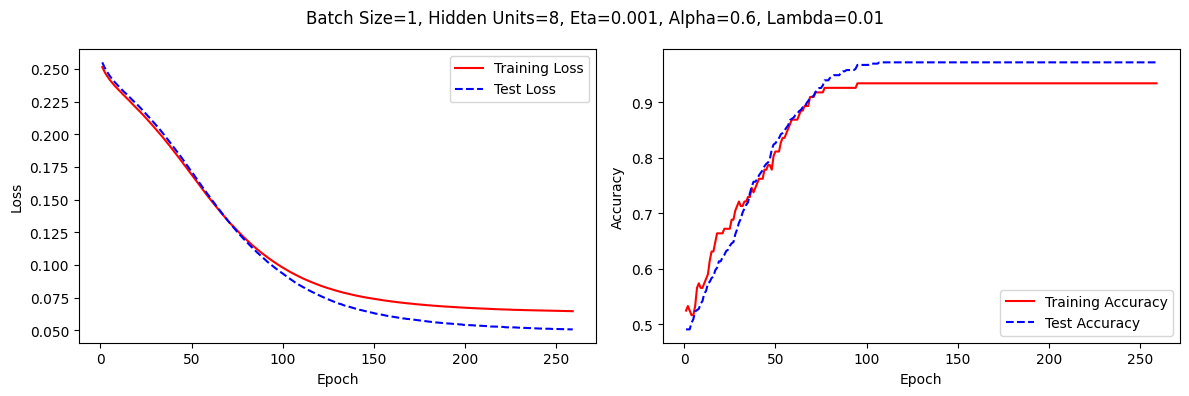

(259,
 0.06466097012710888,
 0.050747399533234046,
 0.9344262295081968,
 0.9722222222222222)

In [ ]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)